In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def calibrate_camera():
    nx, ny = 9, 6
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    objpoints = []
    imgpoints = []
    images = glob.glob('camera_cal/calibration*.jpg')
    
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return mtx, dist

def undistort(img, mtx, dist):
    img_undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return img_undistorted

mtx, dist = calibrate_camera()

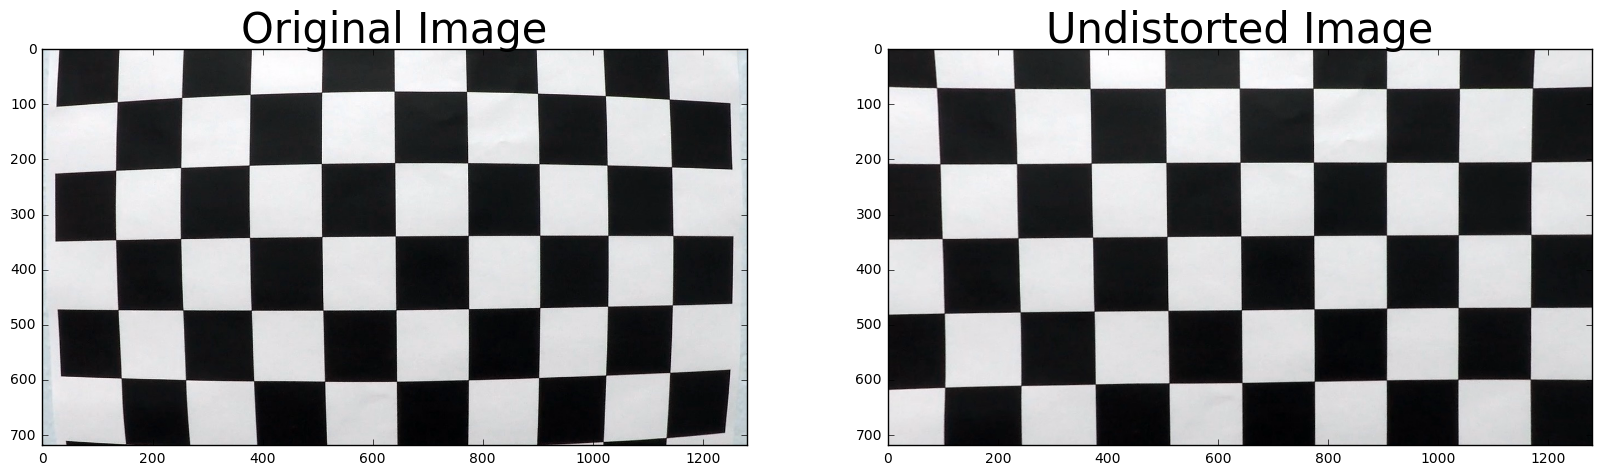

In [3]:
def show_two_images(img1, img2, title1, title2):
    cmap = None if len(img1.shape) == 3 else 'gray'
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img1, cmap=cmap)
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(img2, cmap=cmap)
    ax2.set_title(title2, fontsize=30)

img = cv2.imread('camera_cal/calibration1.jpg')


img_undistorted = undistort(img, mtx, dist)

cv2.imwrite('camera_cal/calibration1_undist.jpg', img_undistorted)

show_two_images(img, img_undistorted, 'Original Image', 'Undistorted Image')

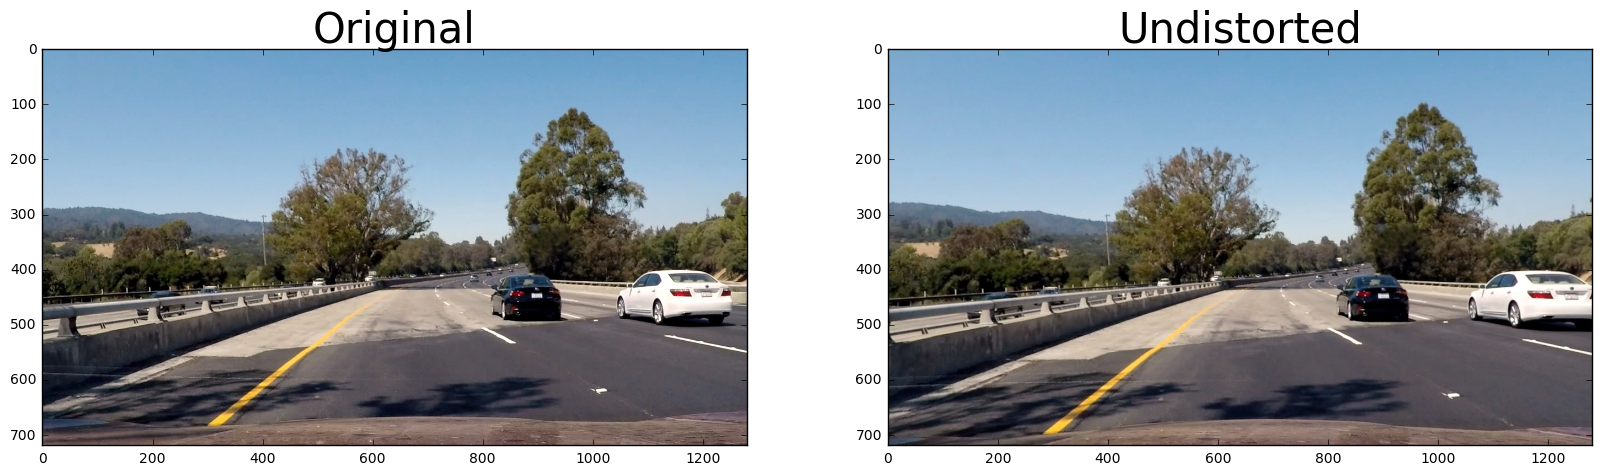

In [4]:
img_file = 'test_images/test4.jpg'
test_image = cv2.imread(img_file)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
undist_ti = undistort(test_image, mtx, dist)
show_two_images(test_image, undist_ti, 'Original', 'Undistorted')


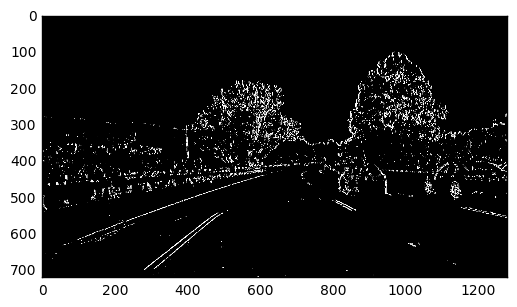

In [5]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

grad_binary_x_ti = abs_sobel_thresh(undist_ti, orient='x', thresh_min=30, thresh_max=100)
plt.imshow(grad_binary_x_ti, cmap='gray')

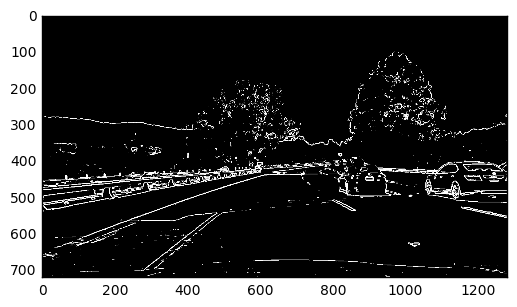

In [6]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

mag_binary_ti = mag_thresh(undist_ti, sobel_kernel=3, mag_thresh=(50, 200))
_, mag_binary_ti = cv2.threshold(mag_binary_ti,0,255,cv2.THRESH_BINARY)
mag_binary_ti = cv2.cvtColor(mag_binary_ti, cv2.COLOR_GRAY2RGB)
plt.imshow(mag_binary_ti, cmap='gray')

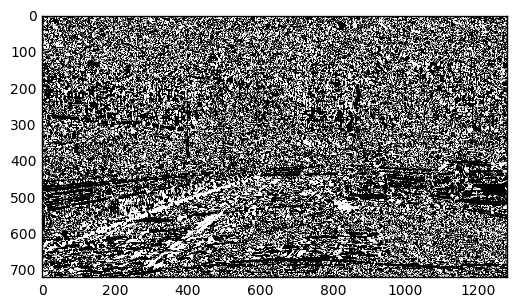

In [7]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output.astype('uint8')

dir_binary_ti = dir_threshold(undist_ti, sobel_kernel=15, thresh=(0.7, 1.3))
plt.imshow(dir_binary_ti, cmap='gray')

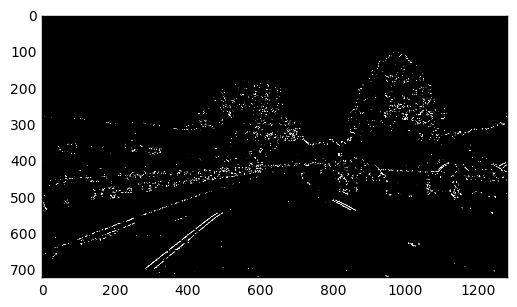

In [8]:
def combine_sobel(image):
    gradx = abs_sobel_thresh(image, orient='x', thresh_min=30, thresh_max=100)
    grady = abs_sobel_thresh(image, orient='y', thresh_min=30, thresh_max=100)
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(50, 200))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.2))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined
combined_sobel = combine_sobel(undist_ti)
plt.imshow(combined_sobel, cmap='gray')

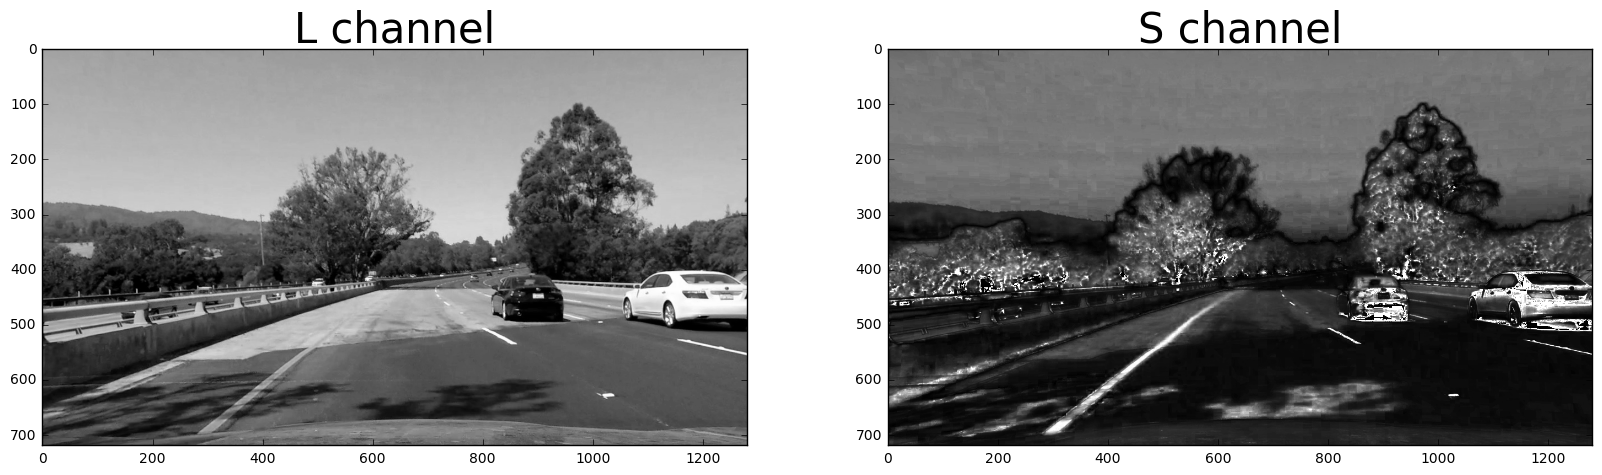

In [9]:
undist_hls = cv2.cvtColor(undist_ti, cv2.COLOR_RGB2HLS)
l_channel = undist_hls[:,:,1]
s_channel = undist_hls[:,:,2]
show_two_images(l_channel, s_channel, 'L channel', 'S channel')

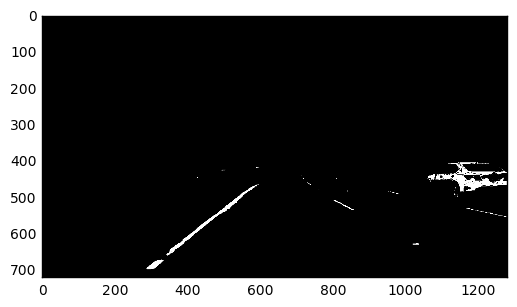

In [10]:
def combine_ls(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = image[:,:,1]
    s_channel = image[:,:,2]
    combined = np.zeros_like(s_channel)
    combined[(s_channel > 150) & (s_channel <= 255) & (l_channel > 100) & (l_channel <= 255)] = 1
    return combined
combined_ls = combine_ls(undist_ti)
plt.imshow(combined_ls, cmap='gray')

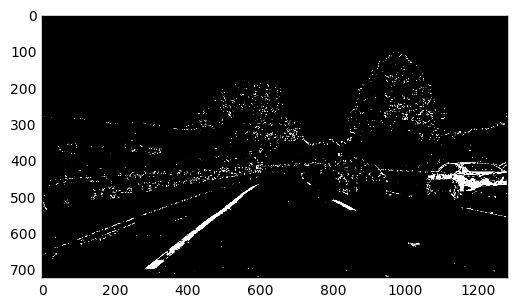

In [11]:
combined = np.zeros_like(combined_sobel)
combined[(combined_sobel == 1) | (combined_ls == 1)] = 1
plt.imshow(combined, cmap='gray')

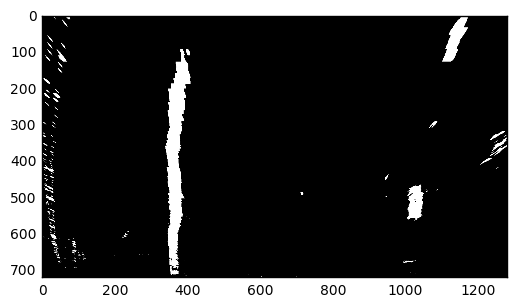

In [12]:
src = np.float32([[585, 460], [203, 720], [1127, 720], [695, 460]])
dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
img_size = (combined.shape[1], combined.shape[0])
binary_warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(binary_warped, cmap='gray')


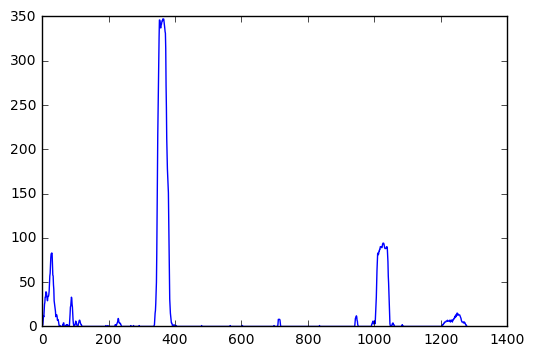

In [13]:
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)

In [14]:
class Window():
    def __init__(self, xlow, xhigh, ylow, yhigh):
        self.xlow = xlow
        self.xhigh = xhigh
        self.ylow = ylow
        self.yhigh = yhigh
        
    @classmethod
    def from_image(cls, image_height, window_height, number, margin, center):
        ylow = image_height - (number + 1) * window_height
        yhigh = image_height - number * window_height
        xlow = center - margin
        xhigh = center + margin
        return cls(xlow, xhigh, ylow, yhigh)
    
    def draw(self, image):
        cv2.rectangle(image, (self.xlow, self.ylow), (self.xhigh, self.yhigh), (0, 255, 0), 2)
        
    def get_nonzero_inds(self, nonzerox, nonzeroy):
        nonzero_inds = ((nonzeroy >= self.ylow) & (nonzeroy < self.yhigh) & 
                        (nonzerox >= self.xlow) & (nonzerox < self.xhigh)).nonzero()[0]
        return nonzero_inds


In [15]:
-

(720,)
(720,)


(720, 0)

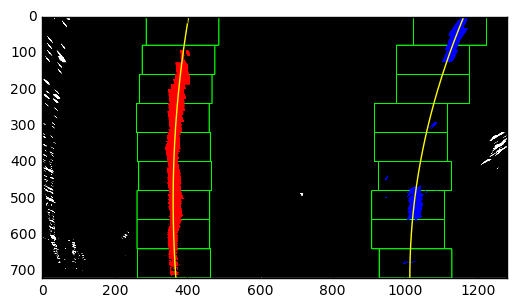

In [16]:
def get_plot_points(img, left_fit, right_fit):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx, ploty

nwindows = 9
margin = 100
minpix = 50
left_lane_inds, right_lane_inds, left_fit, right_fit, left_windows, right_windows = sliding_fit(binary_warped, nwindows, margin, minpix)

# Draw the windows on the visualization image
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
for left_window, right_window in zip(left_windows, right_windows):
    left_window.draw(out_img)
    right_window.draw(out_img)

nonzerox, nonzeroy = get_nonzero_pixels(binary_warped)

# Generate x and y values for plotting
left_fitx, right_fitx, ploty = get_plot_points(img, left_fit, right_fit)
print(left_fitx.shape)
print(ploty.shape)
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [17]:
-

(720,)
(720,)


(720, 0)

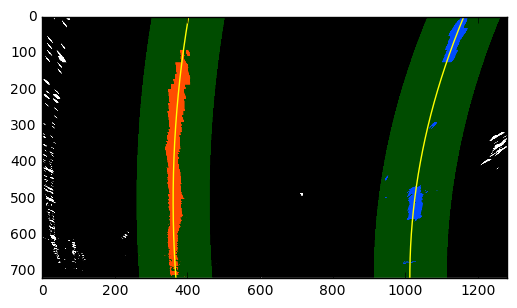

In [18]:
left_lane_inds, right_lane_inds, left_fit, right_fit = easy_fit(binary_warped, left_fit, right_fit, margin)
# Generate x and y values for plotting
left_fitx, right_fitx, ploty = get_plot_points(img, left_fit, right_fit)
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
print(left_fitx.shape)
print(ploty.shape)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [19]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def get_curvatures(binary_warped, left_fit, right_fit):
    left_fitx, right_fitx, ploty = get_plot_points(binary_warped, left_fit, right_fit)
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

def get_car_offset(binary_warped, left_fit, right_fit):
    left_fitx, right_fitx, ploty = get_plot_points(binary_warped, left_fit, right_fit)
    car_center = binary_warped.shape[1] / 2
    lane_center = (right_fitx[-1] - left_fitx[-1])
    offset = (car_center - lane_center) * xm_per_pix
    return offset

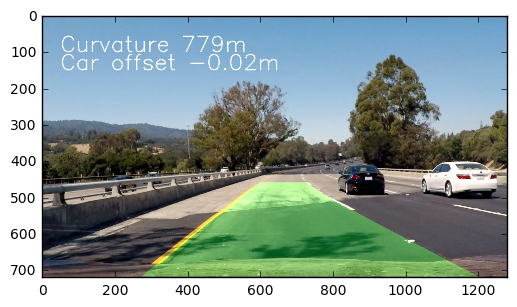

In [20]:
def draw_lane(image, binary_warped, left_fit, right_fit, m_inv):
    left_fitx, right_fitx, ploty = get_plot_points(img, left_fit, right_fit)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, m_inv, (image.shape[1], image.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result

drawed_lane = draw_lane(test_image, binary_warped, left_fit, right_fit, Minv)
curvature = np.mean(get_curvatures(binary_warped, left_fit, right_fit))
car_offset = get_car_offset(binary_warped, left_fit, right_fit)
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(drawed_lane,'Curvature ' + str(int(curvature)) + 'm', (50,100), font, 2,(255,255,255),2,cv2.LINE_AA)
cv2.putText(drawed_lane,'Car offset ' + str(round(car_offset, 2)) + 'm', (50,150), font, 2,(255,255,255),2,cv2.LINE_AA)
plt.imshow(drawed_lane)

In [21]:
class Line():
    def __init__(self, n=5):
        self.fit = []
        self.frame = 0
        self.n = n
        
    def add_fit(self, new_fit):
        if len(self.fit) == self.n:
            del self.fit[0]
        self.fit.append(new_fit)
                        
    def mean_fit(self):
        return np.mean(self.fit, axis=0)


In [22]:
src = np.float32([[585, 460], [203, 720], [1127, 720], [695, 460]])
dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
left_line = Line(10)
right_line = Line(10)

def process_image(image):
    '''Applies the full pipeline to an image.
    
    Notes:
    - The sliding window method is used for the first frame, the easy fit method is used afterwards.
    - The last n (ten) fits are saved. For every frame, lane detection and curvature and car position measurements are derived
    from the average polynomial fits of the last n frames.
    '''
    global left_line
    global right_line
    image = undistort(image, mtx, dist)
    combined_sobel = combine_sobel(image)
    combined_ls = combine_ls(image)
    binary = np.zeros_like(combined_sobel)
    binary[(combined_sobel == 1) | (combined_ls == 1)] = 1
    img_size = (binary.shape[1], binary.shape[0])
    binary_warped = cv2.warpPerspective(binary, M, img_size, flags=cv2.INTER_LINEAR)
    if left_line.frame == 0:
        _, _, left_fit, right_fit, _, _ = sliding_fit(binary_warped, nwindows, margin, minpix)
    else:        
        _, _, left_fit, right_fit = easy_fit(binary_warped, left_line.mean_fit(), right_line.mean_fit(), margin)
    left_line.add_fit(left_fit)
    right_line.add_fit(right_fit)
    left_line.frame += 1
    right_line.frame += 1
    image = draw_lane(image, binary_warped, left_line.mean_fit(), right_line.mean_fit(), Minv)
    curvature = np.mean(get_curvatures(binary_warped, left_line.mean_fit(), right_line.mean_fit()))
    car_offset = get_car_offset(binary_warped, left_line.mean_fit(), right_line.mean_fit())
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image,'Curvature ' + str(int(curvature)) + 'm', (50,100), font, 2,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(image,'Car offset ' + str(round(car_offset, 2)) + 'm', (50,150), font, 2,(255,255,255),2,cv2.LINE_AA)
    return image

In [23]:
output = 'processed.mp4'
clip = VideoFileClip('project_video.mp4')
output_clip = clip.fl_image(process_image)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video processed.mp4
[MoviePy] Writing video processed.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:31<00:00,  2.73it/s]  0%|                                                                                                                         | 1/1261 [00:00<07:16,  2.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed.mp4 

Wall time: 7min 32s
